In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

# -----------------------
# Hyperparameters
# -----------------------
EMBED_DIM = 64
BATCH_SIZE = 128
LR = 3e-4
EPOCHS = 100
REG_LAMBDA = 1e-1
PATIENCE = 5  # Early stopping patience
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# -----------------------
# Data Loading
# -----------------------
train_df = pd.read_csv("../data/train.csv")

unique_users = train_df.user_id.unique()
unique_books = train_df.book_id.unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
book2idx = {b: i for i, b in enumerate(unique_books)}

train_df["user_idx"] = train_df["user_id"].map(user2idx)
train_df["book_idx"] = train_df["book_id"].map(book2idx)

n_users = len(user2idx)
n_books = len(book2idx)

y = train_df["rating"].values
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
train_idx, val_idx = next(splitter.split(train_df, y))

train_data = train_df.iloc[train_idx].reset_index(drop=True)
val_data = train_df.iloc[val_idx].reset_index(drop=True)


class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = df["user_idx"].values
        self.books = df["book_idx"].values
        self.ratings = df["rating"].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.books[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float32),
        )


train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# -----------------------
# Fixed Offset based on User Counts
# -----------------------
user_counts = (
    train_data.groupby("user_idx").size().reindex(range(n_users), fill_value=0).values
)
max_count = user_counts.max()
# normalize count: f_u in [0,1]
normalized_counts = np.log1p(user_counts) / np.log1p(max_count)

# Define fixed offset: from ~3.66 at f_u=0 to ~2.10 at f_u=1
offset_high = 3.66
offset_low = 2.10
# offset(u) = offset_high - (offset_high - offset_low)*f_u
# = offset_high + (offset_low - offset_high)*f_u
offsets = offset_high + (offset_low - offset_high) * normalized_counts
offsets_tensor = torch.tensor(offsets, dtype=torch.float32, device=DEVICE)
# TODO I will get the offsets directly based on the avg rating of the users with the same number of reviews

Using device: mps


In [5]:
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()
count2mean_dict

{1: 3.909282700421941,
 2: 3.7764540995094604,
 3: 2.6917372881355934,
 4: 2.1509026687598114,
 5: 2.165625,
 6: 2.1882008154943935,
 7: 2.213868816008894,
 8: 2.202816901408451,
 9: 2.1195959595959595,
 10: 2.1348214285714286,
 11: 2.095859585958596,
 12: 2.0811965811965814,
 13: 2.0209549071618036,
 14: 2.030920421860019,
 15: 2.094392523364486,
 16: 2.081951530612245,
 17: 2.1029411764705883,
 18: 1.9661246612466126,
 19: 2.1302847282139776,
 20: 2.008189655172414,
 21: 2.065270935960591,
 22: 2.105,
 23: 2.123461853978671,
 24: 2.0411324786324787,
 25: 1.9930434782608695,
 26: 2.0360576923076925,
 27: 2.0755360623781676,
 28: 2.0267857142857144,
 29: 1.9547413793103448,
 30: 2.081609195402299,
 31: 1.9428763440860215,
 32: 2.05234375,
 33: 2.0606060606060606,
 34: 2.102076124567474,
 35: 2.306122448979592,
 36: 1.9102564102564104,
 37: 2.122972972972973,
 38: 2.109907120743034,
 39: 2.1373626373626373,
 40: 2.0631578947368423,
 41: 2.0476718403547673,
 42: 2.2876984126984126,
 43: 

In [ ]:
# Define old offset high/low
offset_high = 3.95
offset_low = 2.10

# Compute the mean rating by exact user count
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()


# Compute offsets now with lookup and fallback
offsets = np.zeros_like(user_counts, dtype=np.float32)
for i, c in enumerate(user_counts):
    if c in count2mean_dict:
        # Use the mean for that count minus global mean as offset
        offsets[i] = count2mean_dict[c]
    else:
        # Fallback to old linear approximation based on normalized counts
        f_u = np.log1p(c) / (np.log1p(max_count) if max_count > 0 else 1.0)
        offsets[i] = offset_high + (offset_low - offset_high) * f_u

offsets_tensor = torch.tensor(offsets, dtype=torch.float32, device=DEVICE)

In [9]:
offsets_tensor

tensor([3.0981, 3.5162, 2.6632,  ..., 3.5162, 3.5162, 3.6600], device='mps:0')

In [13]:
# -----------------------
# Model Definition
# -----------------------
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super(MatrixFactorization, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_ids, item_ids, user_offsets):
        U = self.user_emb(user_ids)
        V = self.item_emb(item_ids)
        u_b = self.user_bias(user_ids).squeeze()
        i_b = self.item_bias(item_ids).squeeze()

        # Add the fixed offset from user_counts
        offset = user_offsets[user_ids]

        pred = (U * V).sum(dim=1) + u_b + i_b + self.global_bias + offset
        return pred


def loss_fn(pred, target, model, reg_lambda):
    mse_loss = nn.MSELoss()(pred, target)
    # L2 regularization on embeddings
    user_reg = model.user_emb.weight.norm(2)
    item_reg = model.item_emb.weight.norm(2)
    return mse_loss + reg_lambda * (user_reg + item_reg)


model = MatrixFactorization(n_users, n_books, EMBED_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for param_group in optimizer.param_groups:
        print("Current learning rate: ", param_group["lr"])
    for users, items, ratings in tqdm(train_loader, total=len(train_loader)):
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        optimizer.zero_grad()
        preds = model(users, items, offsets_tensor)
        loss = loss_fn(preds, ratings, model, REG_LAMBDA)
        loss.backward()
        # Optionally add gradient clipping if needed:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for users, items, ratings in val_loader:
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            ratings = ratings.to(DEVICE)

            preds = model(users, items, offsets_tensor)
            val_loss = nn.MSELoss()(preds, ratings)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    rmse_train = np.sqrt(avg_train_loss)
    rmse_val = np.sqrt(avg_val_loss)
    print(
        f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
    )
    print(f"RMSE Train: {rmse_train:.4f}, RMSE Val: {rmse_val:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_fixed_offset.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered due to no improvement in validation loss.")
            break

# Load best model
model.load_state_dict(torch.load("best_model_fixed_offset.pt"))

# -----------------------
# Test Prediction
# -----------------------
test_df = pd.read_csv("../data/test.csv")
test_df["user_idx"] = test_df["user_id"].map(user2idx)
test_df["book_idx"] = test_df["book_id"].map(book2idx)

# Handle unknown users/items gracefully:
# If unknown user, assign user_idx as a known baseline user or just clamp offset
test_df["user_idx"] = test_df["user_idx"].apply(
    lambda x: x if x in range(n_users) else n_users - 1
)
test_df["book_idx"] = test_df["book_idx"].apply(
    lambda x: x if x in range(n_books) else n_books - 1
)

test_df["user_idx"] = test_df["user_idx"].fillna(n_users - 1).astype(int)
test_df["book_idx"] = test_df["book_idx"].fillna(n_books - 1).astype(int)

model.eval()
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)

with torch.no_grad():
    test_preds = model(test_users, test_items, offsets_tensor).cpu().numpy()

test_preds = np.clip(test_preds, 1.0, 5.0)
submission = pd.DataFrame({"id": test_df["id"], "rating": test_preds})
submission.to_csv("submission.csv", index=False)
print("Created submission.csv")

/Users/saidgurbuz/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 150.09it/s]


Epoch 1/100, Train Loss: 0.8797, Val Loss: 0.8051
RMSE Train: 0.9379, RMSE Val: 0.8973
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 168.49it/s]


Epoch 2/100, Train Loss: 0.7703, Val Loss: 0.7933
RMSE Train: 0.8777, RMSE Val: 0.8907
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 170.80it/s]


Epoch 3/100, Train Loss: 0.7520, Val Loss: 0.7823
RMSE Train: 0.8672, RMSE Val: 0.8845
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 172.81it/s]


Epoch 4/100, Train Loss: 0.7347, Val Loss: 0.7725
RMSE Train: 0.8571, RMSE Val: 0.8789
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 163.83it/s]


Epoch 5/100, Train Loss: 0.7184, Val Loss: 0.7626
RMSE Train: 0.8476, RMSE Val: 0.8732
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.28it/s]


Epoch 6/100, Train Loss: 0.7031, Val Loss: 0.7541
RMSE Train: 0.8385, RMSE Val: 0.8684
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.43it/s]


Epoch 7/100, Train Loss: 0.6888, Val Loss: 0.7462
RMSE Train: 0.8299, RMSE Val: 0.8638
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 169.87it/s]


Epoch 8/100, Train Loss: 0.6752, Val Loss: 0.7390
RMSE Train: 0.8217, RMSE Val: 0.8596
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.72it/s]


Epoch 9/100, Train Loss: 0.6624, Val Loss: 0.7323
RMSE Train: 0.8139, RMSE Val: 0.8557
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.82it/s]


Epoch 10/100, Train Loss: 0.6504, Val Loss: 0.7260
RMSE Train: 0.8065, RMSE Val: 0.8521
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.54it/s]


Epoch 11/100, Train Loss: 0.6391, Val Loss: 0.7208
RMSE Train: 0.7995, RMSE Val: 0.8490
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.51it/s]


Epoch 12/100, Train Loss: 0.6284, Val Loss: 0.7153
RMSE Train: 0.7927, RMSE Val: 0.8458
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.50it/s]


Epoch 13/100, Train Loss: 0.6183, Val Loss: 0.7108
RMSE Train: 0.7863, RMSE Val: 0.8431
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.13it/s]


Epoch 14/100, Train Loss: 0.6087, Val Loss: 0.7064
RMSE Train: 0.7802, RMSE Val: 0.8405
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.05it/s]


Epoch 15/100, Train Loss: 0.5996, Val Loss: 0.7028
RMSE Train: 0.7743, RMSE Val: 0.8383
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.61it/s]


Epoch 16/100, Train Loss: 0.5912, Val Loss: 0.6988
RMSE Train: 0.7689, RMSE Val: 0.8359
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 169.75it/s]


Epoch 17/100, Train Loss: 0.5830, Val Loss: 0.6957
RMSE Train: 0.7635, RMSE Val: 0.8341
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.47it/s]


Epoch 18/100, Train Loss: 0.5752, Val Loss: 0.6925
RMSE Train: 0.7584, RMSE Val: 0.8322
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.52it/s]


Epoch 19/100, Train Loss: 0.5680, Val Loss: 0.6899
RMSE Train: 0.7536, RMSE Val: 0.8306
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.41it/s]


Epoch 20/100, Train Loss: 0.5609, Val Loss: 0.6874
RMSE Train: 0.7490, RMSE Val: 0.8291
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.96it/s]


Epoch 21/100, Train Loss: 0.5544, Val Loss: 0.6850
RMSE Train: 0.7446, RMSE Val: 0.8276
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 163.85it/s]


Epoch 22/100, Train Loss: 0.5481, Val Loss: 0.6827
RMSE Train: 0.7403, RMSE Val: 0.8262
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.15it/s]


Epoch 23/100, Train Loss: 0.5420, Val Loss: 0.6812
RMSE Train: 0.7362, RMSE Val: 0.8253
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.03it/s]


Epoch 24/100, Train Loss: 0.5363, Val Loss: 0.6790
RMSE Train: 0.7323, RMSE Val: 0.8240
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.29it/s]


Epoch 25/100, Train Loss: 0.5308, Val Loss: 0.6776
RMSE Train: 0.7286, RMSE Val: 0.8232
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.27it/s]


Epoch 26/100, Train Loss: 0.5256, Val Loss: 0.6765
RMSE Train: 0.7249, RMSE Val: 0.8225
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 164.02it/s]


Epoch 27/100, Train Loss: 0.5205, Val Loss: 0.6752
RMSE Train: 0.7215, RMSE Val: 0.8217
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.27it/s]


Epoch 28/100, Train Loss: 0.5157, Val Loss: 0.6739
RMSE Train: 0.7181, RMSE Val: 0.8209
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.46it/s]


Epoch 29/100, Train Loss: 0.5111, Val Loss: 0.6729
RMSE Train: 0.7149, RMSE Val: 0.8203
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.35it/s]


Epoch 30/100, Train Loss: 0.5068, Val Loss: 0.6723
RMSE Train: 0.7119, RMSE Val: 0.8199
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 167.02it/s]


Epoch 31/100, Train Loss: 0.5026, Val Loss: 0.6717
RMSE Train: 0.7089, RMSE Val: 0.8196
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.09it/s]


Epoch 32/100, Train Loss: 0.4985, Val Loss: 0.6706
RMSE Train: 0.7061, RMSE Val: 0.8189
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.03it/s]


Epoch 33/100, Train Loss: 0.4947, Val Loss: 0.6699
RMSE Train: 0.7033, RMSE Val: 0.8185
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.69it/s]


Epoch 34/100, Train Loss: 0.4909, Val Loss: 0.6698
RMSE Train: 0.7007, RMSE Val: 0.8184
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.01it/s]


Epoch 35/100, Train Loss: 0.4873, Val Loss: 0.6693
RMSE Train: 0.6981, RMSE Val: 0.8181
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 165.97it/s]


Epoch 36/100, Train Loss: 0.4838, Val Loss: 0.6689
RMSE Train: 0.6955, RMSE Val: 0.8179
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.85it/s]


Epoch 37/100, Train Loss: 0.4805, Val Loss: 0.6688
RMSE Train: 0.6932, RMSE Val: 0.8178
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 166.16it/s]


Epoch 38/100, Train Loss: 0.4773, Val Loss: 0.6683
RMSE Train: 0.6909, RMSE Val: 0.8175
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 167.15it/s]


Epoch 39/100, Train Loss: 0.4742, Val Loss: 0.6682
RMSE Train: 0.6886, RMSE Val: 0.8174
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 169.59it/s]


Epoch 40/100, Train Loss: 0.4711, Val Loss: 0.6680
RMSE Train: 0.6864, RMSE Val: 0.8173
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 170.93it/s]


Epoch 41/100, Train Loss: 0.4684, Val Loss: 0.6677
RMSE Train: 0.6844, RMSE Val: 0.8172
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 170.72it/s]


Epoch 42/100, Train Loss: 0.4655, Val Loss: 0.6677
RMSE Train: 0.6823, RMSE Val: 0.8171
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 171.01it/s]


Epoch 43/100, Train Loss: 0.4628, Val Loss: 0.6678
RMSE Train: 0.6803, RMSE Val: 0.8172
Current learning rate:  0.0003


100%|██████████| 707/707 [00:04<00:00, 170.95it/s]


Epoch 44/100, Train Loss: 0.4602, Val Loss: 0.6683
RMSE Train: 0.6784, RMSE Val: 0.8175
Current learning rate:  0.00015


100%|██████████| 707/707 [00:04<00:00, 170.84it/s]


Epoch 45/100, Train Loss: 0.4557, Val Loss: 0.6681
RMSE Train: 0.6750, RMSE Val: 0.8174
Current learning rate:  0.00015


100%|██████████| 707/707 [00:04<00:00, 171.58it/s]


Epoch 46/100, Train Loss: 0.4545, Val Loss: 0.6682
RMSE Train: 0.6741, RMSE Val: 0.8174
Current learning rate:  0.00015


100%|██████████| 707/707 [00:04<00:00, 170.96it/s]
/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_48962/1117068810.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea

Epoch 47/100, Train Loss: 0.4532, Val Loss: 0.6682
RMSE Train: 0.6732, RMSE Val: 0.8175
Early stopping triggered due to no improvement in validation loss.
Created submission.csv


<Axes: >

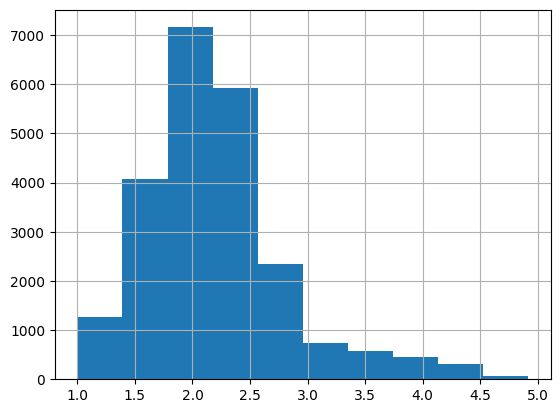

In [29]:
test_df["rating"] = test_preds
user_counts = train_df["user_id"].value_counts()
users_with_less_than_5_reviews = user_counts[user_counts < 55].index

# get the test_df rows with user_ids in users_with_less_than_5_reviews
test_df_filtered = test_df[test_df["user_id"].isin(users_with_less_than_5_reviews)]

# plot the ratings on hist
test_df_filtered["rating"].hist()

In [ ]:
train_df["rating"].value_counts()

rating
2.0    21973
1.0    17689
1.5    15399
2.5    14177
3.0     9863
3.5     8167
4.0     6753
5.0     5577
4.5      925
Name: count, dtype: int64

<Axes: >

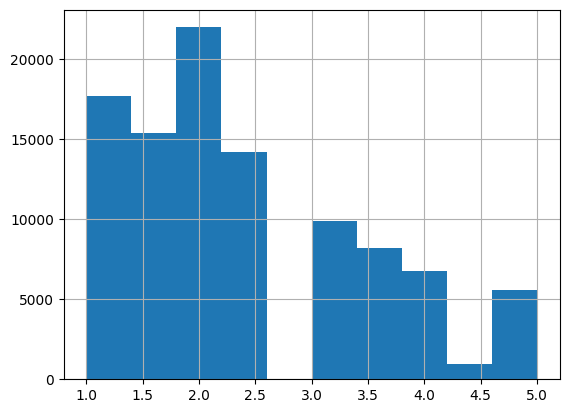

In [ ]:
train_df["rating"].hist()

<Axes: >

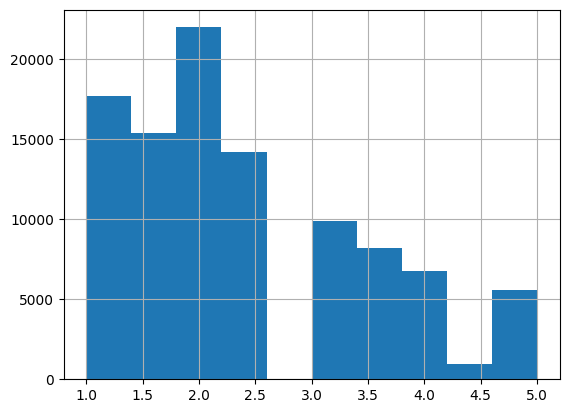

In [28]:
# plot the rating hist in train_df for only the users with less than X (X will be adjustable) reviews
train_df[train_df["user_id"].isin(user_counts[user_counts < 55545].index)][
    "rating"
].hist()

In [ ]:
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean

user_id
1       3.909283
2       3.776454
3       2.691737
4       2.150903
5       2.165625
          ...   
241     2.035270
302     2.173841
314     1.457006
465     1.588172
1841    2.206953
Name: rating, Length: 126, dtype: float64

Number of missing books in test not in train: 0
Book counts:
book_id
408       257
748       213
522       149
356       142
26        142
         ... 
245925      1
247449      1
248220      1
245266      1
249242      1
Name: count, Length: 15712, dtype: int64


<Axes: >

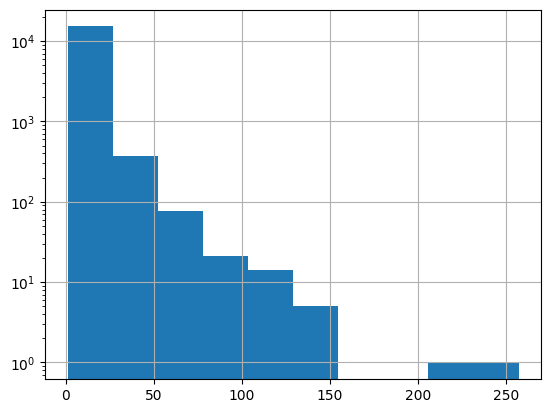

In [7]:
import pandas as pd

test_df = pd.read_csv("../data/test.csv")
train_data = pd.read_csv("../data/train.csv")
test_books = set(test_df["book_id"].unique())
train_books = set(train_data["book_id"].unique())

missing_books = test_books - train_books
print(f"Number of missing books in test not in train: {len(missing_books)}")
if len(missing_books) > 0:
    print("Missing books:", missing_books)


# print number of occurrences of each book in the train data
book_counts = train_data["book_id"].value_counts()
print("Book counts:")
print(book_counts)

# show the occurences histogram in log scale
book_counts.hist(bins=10, log=True)

In [24]:
# sort the rating of the books by the number of occurrences
book_counts_sorted = book_counts.sort_values(ascending=False)
print("Book counts sorted:")
print(book_counts_sorted)

# show the top 10 books with the most occurrences
top_books = book_counts_sorted.head(100)
print("Top books:")
print(top_books)

# get the each avg rating of the top books
top_books_ratings = (
    train_data[train_data["book_id"].isin(top_books.index)]
    .groupby("book_id")["rating"]
    .mean()
)
print("Top books ratings:")
print(top_books_ratings)

Book counts sorted:
book_id
408       257
748       213
522       149
356       142
26        142
         ... 
245793      1
249072      1
248519      1
66651       1
249242      1
Name: count, Length: 15712, dtype: int64
Top books:
book_id
408     257
748     213
522     149
356     142
26      142
       ... 
5873     58
2527     57
2488     57
516      56
1051     56
Name: count, Length: 100, dtype: int64
Top books ratings:
book_id
18        2.256944
26        3.915493
28        2.065789
37        1.453271
67        1.898810
            ...   
5873      1.974138
5887      1.768116
6330      1.427536
6933      1.406780
243217    4.206349
Name: rating, Length: 100, dtype: float64
